In [7]:
import pandas as pd
import numpy as np

from src.scripts import smiles
from src.scripts import targets
from src.utils import utils

%load_ext autoreload

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import plotly.graph_objects as go
from matplotlib.patches import Patch

# learning
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# rdkit tools
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

import json
from tqdm import tqdm

tqdm.pandas()

# Looking at a sample

In [3]:
mol_df = (
    pd.read_csv(
        "../data/BindingDB_All.tsv",
        sep="\t",
        usecols=[
            "BindingDB Reactant_set_id",
            "Ligand SMILES",
            "BindingDB Ligand Name",
            "IC50 (nM)",
            "UniProt (SwissProt) Primary ID of Target Chain",
        ],
    )
    .dropna()
    .sample(10000, random_state=0)
)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
descriptors = mol_df["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
isdict = lambda x: isinstance(x, dict)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(isdict)].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)

In [ ]:
to_drop = utils.collinear_cols(descriptors_df, threshold=0.9)
print(descriptors_df.columns.to_list())
print(to_drop)
print(len(to_drop))

In [23]:
descriptors_df

,Molecular Weight,C LogP,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,...,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons
1493227,447.501,4.20550,0.458333,-2.74,32.0,419.277,1.610108e+07,22.453803,9.402350,5.176748,...,2.0,4.0,0.0,8.0,0.0,6.0,0.0,1.0,1.0,172.0
384364,413.507,1.76940,0.473684,-2.59,29.0,390.323,7.452830e+06,18.439320,7.342386,3.815837,...,2.0,9.0,2.0,10.0,0.0,4.0,1.0,2.0,3.0,152.0
1577050,592.700,5.19628,0.181818,-5.01,43.0,563.468,5.148955e+09,29.481271,13.313440,7.640180,...,5.0,8.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,216.0
977575,762.685,7.66038,0.375000,-4.47,53.0,723.373,8.137545e+11,36.870152,16.269416,8.847310,...,4.0,8.0,2.0,13.0,0.0,15.0,0.0,2.0,2.0,276.0
670060,372.428,4.72010,0.136364,-3.67,28.0,352.268,3.293984e+06,17.729330,7.520458,3.572130,...,4.0,6.0,1.0,6.0,0.0,5.0,0.0,0.0,0.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325491,404.257,3.30138,0.277778,-2.69,27.0,389.137,1.995341e+06,17.710308,6.798781,2.910251,...,3.0,5.0,2.0,9.0,0.0,4.0,0.0,0.0,0.0,138.0
2427929,316.455,2.93580,0.333333,-1.50,21.0,300.327,1.342867e+05,13.182963,5.363905,2.661712,...,3.0,6.0,1.0,6.0,0.0,2.0,0.0,0.0,0.0,108.0
1503242,405.506,2.79392,0.409091,-3.13,30.0,378.290,6.572977e+06,20.155338,8.314052,4.088769,...,3.0,8.0,1.0,8.0,0.0,4.0,0.0,1.0,1.0,156.0
1996056,199.257,1.47600,0.250000,-1.79,15.0,186.153,4.014255e+03,9.753174,4.157882,2.171589,...,2.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,76.0


In [29]:
normilzed_df = (
    descriptors_df / descriptors_df["Molecular Weight"].to_numpy().reshape(10000, 1)
).drop("Molecular Weight", axis=1)
to_drop = utils.collinear_cols(normilzed_df, threshold=0.9)
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(normilzed_df.dropna())
    .drop(to_drop, axis=1)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = (
    (smiles.get_IC50(mol_df.loc[X.index])).replace([np.inf, -np.inf], np.nan).dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.664
Date:                Tue, 03 Dec 2024   Prob (F-statistic):             0.0153
Time:                        16:09:23   Log-Likelihood:            -1.7716e+05
No. Observations:                9988   AIC:                         3.544e+05
Df Residuals:                    9959   BIC:                         3.546e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C LogP                  

In [ ]:
sns.pairplot(
    pd.merge(descriptors_df, mol_df, how="inner", left_index=True, right_index=True)[
        [
            "Molecular Weight",
            "NumAromaticRings",
            "NumHAcceptors",
            "NumHDonors",
            "NumHeteroatoms",
            "NumRotatableBonds",
            "NumSaturatedCarbocycles",
            "NumSaturatedHeterocycles",
            "NumSaturatedRings",
            "NumValenceElectrons",
            "IC50 (nM)",
        ]
    ].sample(100, random_state=0)
)

In [51]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.sample(5000, random_state=0).dropna())
)
y = smiles.get_IC50(mol_df.loc[X.index])

In [56]:
mol_df["IC50 (nM)"] = smiles.get_IC50(mol_df)

In [ ]:
import statsmodels.api as sm

model = sm.OLS(endog=y, exog=X, hasconst=True)
np.random.seed(42)
model = model.fit()
print(model.summary())

In [ ]:
descriptors_df

In [ ]:
descriptors_df.index

In [30]:
%autoreload 2

In [ ]:
pd.merge(descriptors_df, mol_df, how="inner", left_index=True, right_index=True)

# Restricting to one protein

In [30]:
# target_df = mol_df[
#     mol_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
# ].drop_duplicates('Ligand SMILES')#dropna(subset=["Ligand SMILES", "IC50 (nM)"])

target_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
    ],
).drop_duplicates("Ligand SMILES")
target_df["IC50 (nM)"] = smiles.get_IC50(target_df)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_73745/1032142100.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [31]:
target_df = target_df[
    target_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]
descriptors = target_df["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
isdict = lambda x: isinstance(x, dict)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(isdict)].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
merged_df = pd.merge(
    target_df, descriptors_df, how="inner", left_index=True, right_index=True
)

 67%|██████▋   | 2621/3907 [00:17<00:07, 160.98it/s][16:11:15] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[16:11:15] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
100%|██████████| 3907/3907 [00:24<00:00, 162.27it/s]


In [ ]:
from sklearn.preprocessing import StandardScaler

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = (
    (smiles.get_IC50(target_df.loc[X.index]))
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit_regularized(alpha=100)
print(model.summary())

In [36]:
to_drop

['MaxEStateIndex',
 'MinAbsPartialCharge',
 'MinPartialCharge',
 'MolLogP',
 'NumHDonors',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings']

In [38]:
normilzed_df = (
    descriptors_df / descriptors_df["Molecular Weight"].to_numpy().reshape(3907, 1)
).drop("Molecular Weight", axis=1)
target_df = target_df[
    target_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]
to_drop = utils.collinear_cols(normilzed_df, threshold=0.9)
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(normilzed_df.dropna())
    .drop(to_drop, axis=1)
    .dropna()
)
y = (
    (smiles.get_IC50(target_df.loc[X.index]))
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     9.475
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           3.54e-35
Time:                        16:13:53   Log-Likelihood:                -42316.
No. Observations:                3899   AIC:                         8.468e+04
Df Residuals:                    3873   BIC:                         8.485e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C LogP                  

In [ ]:
print(y.isna().sum())  # Check for missing values
print(y.isin([np.inf, -np.inf]).sum())  # Check for infinite values

In [ ]:
sns.pairplot(
    merged_df[
        [
            "Molecular Weight",
            "NumAromaticRings",
            "NumHAcceptors",
            "NumHDonors",
            "NumHeteroatoms",
            "NumRotatableBonds",
            "NumSaturatedCarbocycles",
            "NumSaturatedHeterocycles",
            "NumSaturatedRings",
            "NumValenceElectrons",
            "Kappa1",
            "IC50 (nM)",
        ]
    ].sample(500, random_state=0)
)

In [ ]:
merged_df["IC50 (nM)"]

In [151]:
target_df["IC50 (nM)"] += 1

In [ ]:
np.logspace(0, 6, 7)

In [ ]:
ax = sns.histplot(target_df, x="IC50 (nM)", bins=np.logspace(0, 6, 7))
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
np.log(smiles.get_IC50(target_df.loc[X.index]))

In [ ]:
corr_matrix = X.corr()
print(corr_matrix)  # .to_numpy().diagonal())

# Summary regularized

In [ ]:
from sklearn.preprocessing import StandardScaler

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = (
    (smiles.get_IC50(target_df.loc[X.index]))
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # Rep
X = X.loc[y.index]
model = sm.OLS(endog=y, exog=X, hasconst=True)
model = model.fit_regularized(alpha=10000)
model.params

In [ ]:
results = []
for i in np.logspace(0, 4, 40):
    model = sm.OLS(endog=y, exog=X, hasconst=True).fit_regularized(alpha=i)
    results.append(model.params)
results_df = pd.DataFrame(results)
results_df.index = np.logspace(0, 4, len(results))
results_df

In [ ]:
import plotly.express as px

# Plot the line plot using Plotly Express
fig = px.line(
    results_df,
    title="Line Plot with Logarithmic X-Axis",
    labels={"x": "X-Axis Label", "y": "Y-Axis Label"},
)

# Set the x-axis to logarithmic scale
fig.update_layout(xaxis_type="log")

# Show the plot
fig.show()

In [ ]:
# Plot the line plot using Plotly Express
fig = px.line(
    np.abs(results_df).sum(axis=1),
    title="Line Plot with Logarithmic X-Axis",
    labels={"x": "X-Axis Label", "y": "Y-Axis Label"},
)

# Set the x-axis to logarithmic scale
fig.update_layout(xaxis_type="log")

# Show the plot
fig.show()

# Looking with citations

In [242]:
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations).sort_values(by="citation", ascending=False)

In [ ]:
target_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Article DOI",
    ],
).drop_duplicates("Ligand SMILES")
target_df["IC50 (nM)"] = smiles.get_IC50(target_df)

In [ ]:
citations_df

In [269]:
target_df = pd.merge(target_df, citations_df, left_on="Article DOI", right_on="doi")

In [ ]:
target_df.drop("IC50 (nM)", axis=1).dropna()

In [ ]:
ret_df = target_df.drop("IC50 (nM)", axis=1).dropna()[
    target_df.drop("IC50 (nM)", axis=1).dropna()[
        "UniProt (SwissProt) Primary ID of Target Chain"
    ]
    == "P07949"
]
descriptors = ret_df["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
isdict = lambda x: isinstance(x, dict)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(isdict)].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
ret_df = pd.merge(
    ret_df, descriptors_df, how="inner", left_index=True, right_index=True
)

In [ ]:
ret_df

In [ ]:
ret_df["citation"]

In [319]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)  # [['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
y = ret_df["citation"] > ret_df["citation"].mean()  # Rep
X = X.loc[y.index]
model = LogisticRegression(penalty="l1", C=1, solver="liblinear").fit(X, y)

In [ ]:
model.coef_.reshape(38)

In [ ]:
ax = sns.histplot(ret_df, x="citation")
# ax.set_xscale('log')

In [ ]:
results = []
for i in np.logspace(0, 1, 40):
    model = LogisticRegression(
        penalty="l1", C=1 / (i - 0.99999), solver="liblinear"
    ).fit(X, y)
    results.append(model.coef_.reshape(38))
results_df = pd.DataFrame(
    np.stack(results), index=np.logspace(0, 4, len(results)), columns=X.columns
)


fig = px.line(
    results_df,
    title="Lasso plot of coefs",
    labels={"x": "alpha regularisation strength", "y": "coefs"},
)

# Set the x-axis to logarithmic scale
fig.update_layout(xaxis_type="log")

# Show the plot
fig.show()

In [ ]:
for res in results()

In [ ]:
model.coef_.shape

In [ ]:
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()
print(model.summary())

# Fingerprints

In [ ]:
sample_df = target_df.dropna().sample(int(1e4), random_state=0)
sample_df[[f"FP{i}" for i in np.arange(2048)]] = np.stack(
    sample_df["Ligand SMILES"].progress_apply(smiles.get_fingerprint)
)

In [ ]:
print(model.summary())

In [ ]:
ret_df = target_df[
    target_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]
ret_df[[f"FP{i}" for i in np.arange(2048)]] = np.stack(
    ret_df["Ligand SMILES"].apply(smiles.get_fingerprint)
)

In [435]:
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(ret_df[[f"FP{i}" for i in np.arange(2048)]])
)  # .replace([np.inf, -np.inf], np.nan).dropna()#[['Molecular Weight','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','NumValenceElectrons']]
pca = PCA(200).set_output(transform="pandas")
X = pca.fit_transform(X)
# y=ret_df['citation'].dropna()
y = smiles.get_IC50(target_df.loc[X.index]).dropna()
X = X.loc[y.index]
# model = Lasso(alpha=0).fit(X,y)
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()

In [57]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso

In [41]:
ligand_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
    ],
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_73745/1808430885.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [68]:
# Loading Descriptors
descriptors = (
    ligand_df.dropna()["Ligand SMILES"]
    .sample(10000)
    .progress_apply(smiles.get_MolDescriptors)
)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(lambda x: isinstance(x, dict))].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
to_drop = utils.collinear_cols(descriptors_df, threshold=0.9)

 16%|█▌        | 1575/10000 [00:11<00:45, 186.29it/s][16:50:47] Can't kekulize mol.  Unkekulized atoms: 20 21 23 24 26
[16:50:47] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
100%|██████████| 10000/10000 [00:59<00:00, 167.51it/s]


In [89]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


numerical_cols = [
    "Molecular Weight",
    "C LogP",
    "FractionCSP3",
    "HallKierAlpha",
    "HeavyAtomCount",
    "HeavyAtomMolWt",
    "Ipc",
    "Kappa1",
    "Kappa2",
    "Kappa3",
    "LabuteASA",
    "MaxAbsEStateIndex",
    "MaxAbsPartialCharge",
    "MaxEStateIndex",
    "MaxPartialCharge",
    "MinAbsEStateIndex",
    "MinAbsPartialCharge",
    "MinEStateIndex",
    "MinPartialCharge",
    "MolLogP",
    "MolMR",
]
categorical_cols = [
    "NHOHCount",
    "NOCount",
    "NumAliphaticCarbocycles",
    "NumAliphaticHeterocycles",
    "NumAliphaticRings",
    "NumAromaticCarbocycles",
    "NumAromaticHeterocycles",
    "NumAromaticRings",
    "NumHAcceptors",
    "NumHDonors",
    "NumHeteroatoms",
    "NumRadicalElectrons",
    "NumRotatableBonds",
    "NumSaturatedCarbocycles",
    "NumSaturatedHeterocycles",
    "NumSaturatedRings",
    "NumValenceElectrons",
]


# Preprocessing for numeric features

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# Preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
)

# Combine preprocessors into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Build the complete pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ('model', Lasso(alpha=alpha))
    ]
).set_output(transform="pandas")

X = pipeline.fit_transform(descriptors_df.dropna())
y = smiles.get_IC50(ligand_df.iloc[X.index])

In [92]:
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.341
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.35e-06
Time:                        17:01:48   Log-Likelihood:            -1.7575e+05
No. Observations:                9976   AIC:                         3.525e+05
Df Residuals:                    9487   BIC:                         3.560e+05
Df Model:                         488                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
num_

## Just in RET

In [93]:
descriptors = ligand_df.dropna()[
    ligand_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
]["Ligand SMILES"].progress_apply(smiles.get_MolDescriptors)
ret_descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(lambda x: isinstance(x, dict))].to_list(),
    index=descriptors[descriptors.apply(isdict)].index,
)
X = pipeline.fit_transform(ret_descriptors_df.dropna())
y = smiles.get_IC50(ligand_df.iloc[X.index])
model = sm.OLS(endog=y, exog=X, hasconst=True).fit()
print(model.summary())

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_73745/794838224.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  descriptors=ligand_df.dropna()[ligand_df['UniProt (SwissProt) Primary ID of Target Chain']=='P07949']['Ligand SMILES'].progress_apply(smiles.get_MolDescriptors)
 12%|█▏        | 3077/26363 [00:20<02:35, 150.16it/s][17:04:55] Explicit valence for atom # 35 N, 4, is greater than permitted
[17:04:55] Explicit valence for atom # 35 N, 4, is greater than permitted
 48%|████▊     | 12541/26363 [01:26<01:11, 192.57it/s][17:06:01] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[17:06:01] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
 67%|██████▋   | 17760/26363 [02:05<01:04, 133.55it/s][17:06:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:06:40] Explicit valence for atom # 17 N, 4, is greater than permitted
[17:06:40] Explicit valence for atom # 17 N, 4, is greater than permitted
100%|██████████| 26363/2636

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     19.37
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:07:37   Log-Likelihood:            -2.6483e+05
No. Observations:               26352   AIC:                         5.301e+05
Df Residuals:                   26143   BIC:                         5.318e+05
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
num__M

# Establishing Pipeline

## Loading Data and Imports

In [2]:
import pandas as pd
import numpy as np

from src.scripts import smiles
from src.scripts import targets
import src.utils

%load_ext autoreload

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

# learning
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# rdkit tools
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

import json
from tqdm import tqdm

tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Importing data
ligand_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Article DOI",
    ],
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_47216/1745759626.py:2: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  ligand_df = pd.read_csv(


In [4]:
descriptors = ligand_df.dropna(
    subset=["Ligand SMILES", "UniProt (SwissProt) Primary ID of Target Chain"]
)[ligand_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"][
    "Ligand SMILES"
].progress_apply(
    smiles.get_MolDescriptors
)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(lambda x: isinstance(x, dict))].to_list(),
    index=descriptors[descriptors.apply(lambda x: isinstance(x, dict))].index,
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_24494/2654875346.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  descriptors = ligand_df.dropna(subset=["Ligand SMILES","UniProt (SwissProt) Primary ID of Target Chain"])[
 12%|█▏        | 3123/26807 [00:19<02:15, 174.70it/s][15:22:13] Explicit valence for atom # 35 N, 4, is greater than permitted
[15:22:13] Explicit valence for atom # 35 N, 4, is greater than permitted
 47%|████▋     | 12578/26807 [01:15<01:02, 229.07it/s][15:23:09] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[15:23:09] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
 66%|██████▋   | 17808/26807 [01:44<00:54, 164.07it/s][15:23:39] Explicit valence for atom # 17 N, 4, is greater than permitted
[15:23:39] Explicit valence for atom # 17 N, 4, is greater than permitted
100%|██████████| 26807/26807 [02:33<00:00, 175.01it/s]


## For IC50

In [7]:
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
)
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()
y = pd.cut(
    y, bins=np.logspace(0, np.log(y.max()), num=10) - 1, labels=np.arange(9)
).dropna()
X = X.loc[y.index]

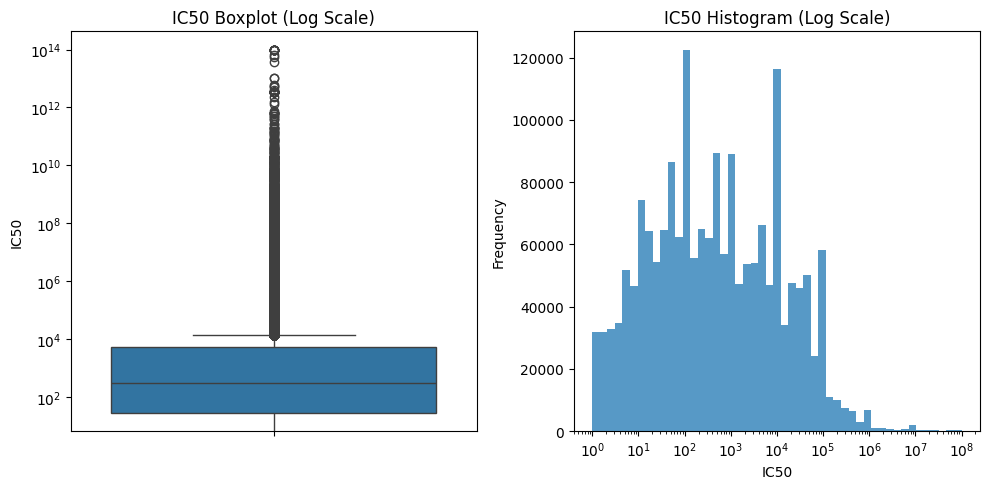

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=smiles.get_IC50(ligand_df).dropna(), ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("IC50 Boxplot (Log Scale)")
axes[0].set_ylabel("IC50")
axes[0].set_xlabel("")

sns.histplot(
    data=smiles.get_IC50(ligand_df).dropna(), bins=np.logspace(0, 8), ax=axes[1]
)
axes[1].set_xscale("log")
axes[1].set_title("IC50 Histogram (Log Scale)")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("IC50")

plt.tight_layout()
plt.show()

### Random Forest (MDI)

In [9]:
# Train the Random Forest Regressor
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.95)
rf.fit(X.drop(to_drop, axis=1), y)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_24494/3344731454.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mdi_df.columns, rotation=90)


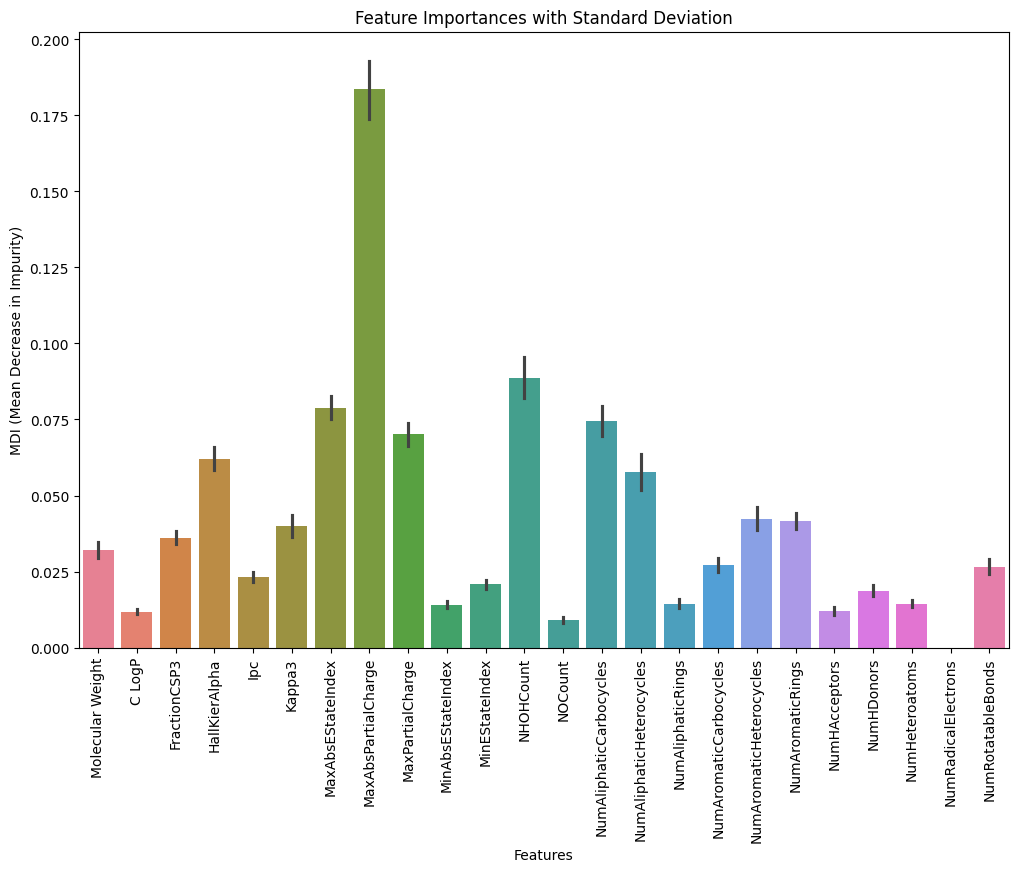

In [10]:
mdi_df = pd.DataFrame(
    data=[tree.feature_importances_ for tree in rf.estimators_],
    columns=X.drop(to_drop, axis=1).columns,
)  # drop(to_drop,axis=1).columns)

# Visualize the feature importances with Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=mdi_df,
)
ax.set_xticklabels(mdi_df.columns, rotation=90)
ax.set_ylabel("MDI (Mean Decrease in Impurity)")
ax.set_xlabel("Features")
ax.set_title("Feature Importances with Standard Deviation")
plt.show()

### Logistic Regression

In [52]:
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
)
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()
y = y[y < 2e5]
y = pd.cut(y, bins=np.logspace(0, 5, num=5, base=10) - 1, labels=np.arange(4)).dropna()
X = X.loc[y.index]

# Train the Random Forest Regressor
lr = LogisticRegression(max_iter=1000, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.95)
lr.fit(X.drop(to_drop, axis=1), y)

LogisticRegression(max_iter=1000, random_state=42)

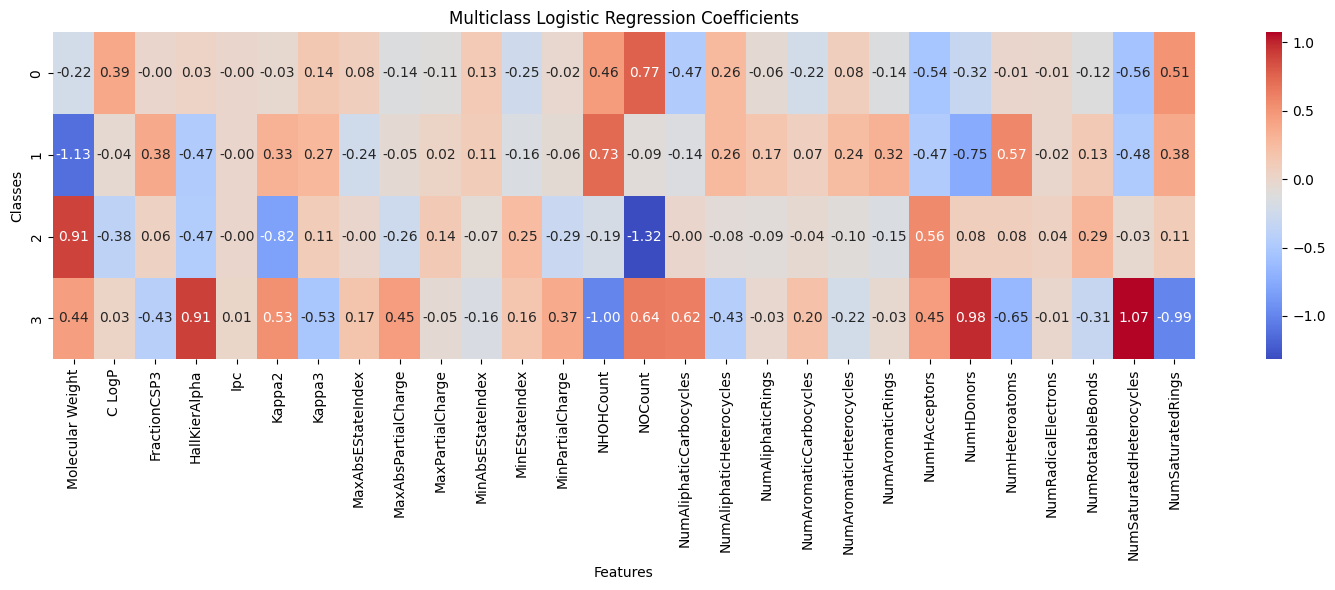

In [54]:
# Create a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(
    lr.coef_,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=X.drop(to_drop, axis=1).columns,
    yticklabels=np.arange(4),
)
plt.title("Multiclass Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

### With Statsmodels

In [43]:
from statsmodels.discrete.discrete_model import MNLogit

X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
)
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()
y = y[y < 2e5]
y = pd.cut(y, bins=np.logspace(0, 5, num=5, base=10) - 1, labels=np.arange(4)).dropna()
X = X.loc[y.index]

lr = LogisticRegression(max_iter=1000, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.9)
log_reg = MNLogit(y, X.drop(to_drop + ["NumRadicalElectrons", "Ipc"], axis=1)).fit(
    maxiter=100
)

print(log_reg.summary())

         Current function value: 1.222098
         Iterations: 100


/Users/guillaumebelissent/opt/anaconda3/envs/aada/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:              IC50 (nM)   No. Observations:                26323
Model:                        MNLogit   Df Residuals:                    26269
Method:                           MLE   Df Model:                           51
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                 -0.1215
Time:                        15:55:18   Log-Likelihood:                -32169.
converged:                      False   LL-Null:                       -28685.
Covariance Type:            nonrobust   LLR p-value:                     1.000
             IC50 (nM)=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Molecular Weight             0.7916      0.084      9.373      0.000       0.626       0.957
C LogP                      -0.3578      0.039     -9.058      0.000      -0.435      -0.

/Users/guillaumebelissent/opt/anaconda3/envs/aada/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:5475: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


In [73]:
y.value_counts()

IC50 (nM)
1    14176
0     6432
2     5018
3      697
Name: count, dtype: int64

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_24494/3586401629.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  significance = p_values.applymap(significance_stars)


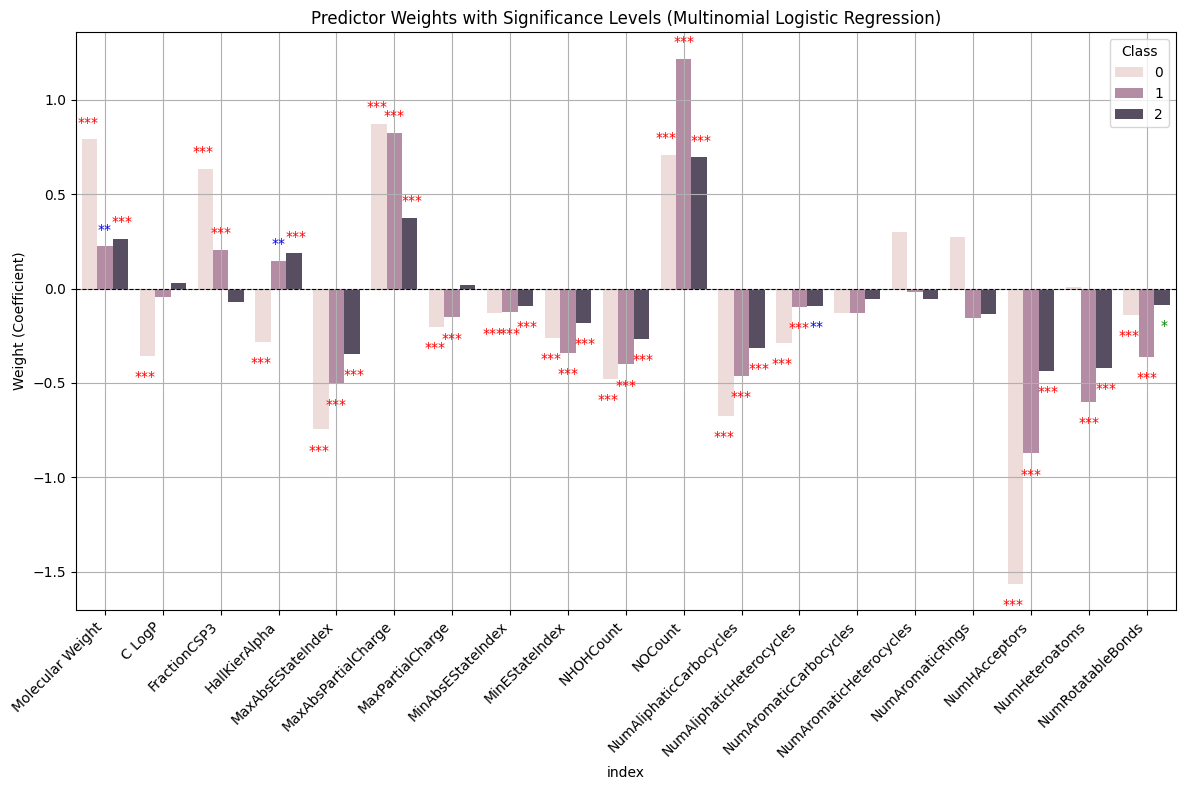

In [72]:
p_values = log_reg.pvalues
weights = log_reg.params


# Define significance levels
def significance_stars(p):
    if p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return ""


# Apply significance levels to p-values
significance = p_values.applymap(significance_stars)

# Combine weights and p-values into a single DataFrame for plotting
weights_melt = weights.reset_index().melt(
    id_vars="index", var_name="Class", value_name="Weight"
)
p_values_melt = p_values.reset_index().melt(
    id_vars="index", var_name="Class", value_name="P-Value"
)
significance_melt = significance.reset_index().melt(
    id_vars="index", var_name="Class", value_name="Significance"
)

# Merge data for plotting
combined = weights_melt.merge(p_values_melt, on=["index", "Class"]).merge(
    significance_melt, on=["index", "Class"]
)

# Plot paired bars
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=combined, x="index", y="Weight", hue="Class", dodge=True, alpha=0.8
)

# Annotate stars for significance
for i, row in combined.iterrows():
    if row["Significance"]:  # Only annotate significant predictors
        plt.text(
            x=i % len(weights.index)
            + (row["Class"] - 1) * 0.3,  # Adjust x position for paired bars
            y=row["Weight"]
            + (0.05 if row["Weight"] > 0 else -0.15),  # Position above or below bar
            s=row["Significance"],
            color="r"
            if row["Significance"] == "***"
            else (
                "b"
                if row["Significance"] == "**"
                else ("g" if row["Significance"] == "*" else "k")
            ),
            ha="center",
            va="bottom",
            size=10,
        )

# Customize the plot
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax.set_title(
    "Predictor Weights with Significance Levels (Multinomial Logistic Regression)"
)
ax.set_ylabel("Weight (Coefficient)")
ax.set_label("Predictor")
plt.legend(title="Class")
ax.set_xticks(ticks=np.arange(len(combined["index"].unique())))
ax.set_xticklabels(labels=combined["index"].unique(), rotation=45, ha="right")
ax.grid()
plt.tight_layout()
plt.show()

In [76]:
y

44870      1
45826      1
45827      2
45828      1
45829      1
          ..
2904329    0
2906656    1
2906657    1
2907596    1
2907597    1
Name: IC50 (nM), Length: 26323, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [75]:
y.value_counts()

IC50 (nM)
1    14176
0     6432
2     5018
3      697
Name: count, dtype: int64

In [77]:
np.logspace(0, 5, num=5, base=10) - 1

array([0.00000000e+00, 1.67827941e+01, 3.15227766e+02, 5.62241325e+03,
       9.99990000e+04])

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_24494/3768558648.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  significance = p_values.applymap(significance_stars)


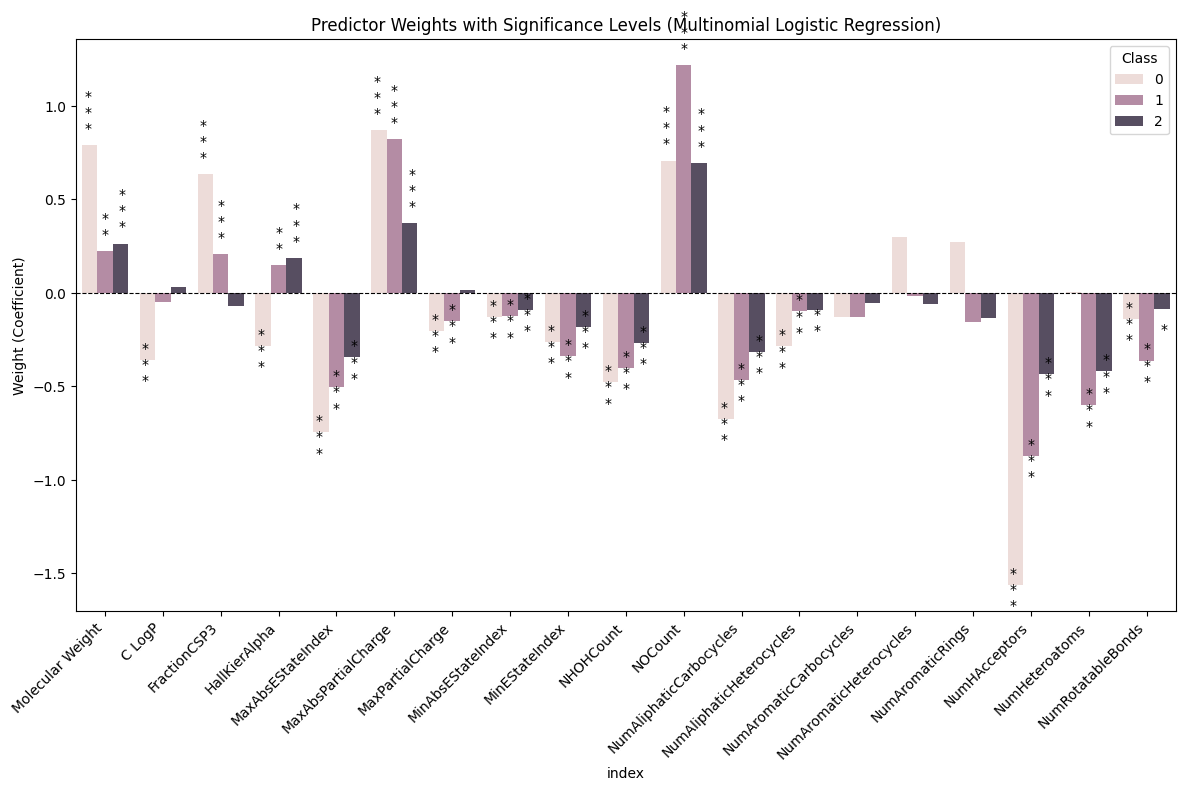

In [66]:
combinedp_values = log_reg.pvalues
weights = log_reg.params


# Define significance levels
def significance_stars(p):
    if p <= 0.001:
        return "*\n*\n*"
    elif p <= 0.01:
        return "*\n*"
    elif p <= 0.05:
        return "*"
    else:
        return ""


# Apply significance levels to p-values
significance = p_values.applymap(significance_stars)

# Combine weights and p-values into a single DataFrame for plotting
weights_melt = weights.reset_index().melt(
    id_vars="index", var_name="Class", value_name="Weight"
)
p_values_melt = p_values.reset_index().melt(
    id_vars="index", var_name="Class", value_name="P-Value"
)
significance_melt = significance.reset_index().melt(
    id_vars="index", var_name="Class", value_name="Significance"
)

# Merge data for plotting
combined = weights_melt.merge(p_values_melt, on=["index", "Class"]).merge(
    significance_melt, on=["index", "Class"]
)

# Plot paired bars
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=combined, x="index", y="Weight", hue="Class", dodge=True, alpha=0.8
)

# Annotate stars for significance
for i, row in combined.iterrows():
    if row["Significance"]:  # Only annotate significant predictors
        plt.text(
            x=i % len(weights.index)
            + (row["Class"] - 1) * 0.3,  # Adjust x position for paired bars
            y=row["Weight"]
            + (0.05 if row["Weight"] > 0 else -0.15),  # Position above or below bar
            s=row["Significance"],
            color="black",
            ha="center",
            va="bottom",
            size=10,
        )

# Customize the plot
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax.set_title(
    "Predictor Weights with Significance Levels (Multinomial Logistic Regression)"
)
ax.set_ylabel("Weight (Coefficient)")
ax.set_label("Predictor")
plt.legend(title="Class")
ax.set_xticks(ticks=np.arange(len(combined["index"].unique())))
ax.set_xticklabels(labels=combined["index"].unique(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Using Citations

In [79]:
# Importing data
ligand_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Article DOI",
    ],
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_6767/2467305793.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  ligand_df = pd.read_csv(


In [84]:
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations).sort_values(by="citation", ascending=False)
citations_df = pd.merge(ligand_df, citations_df, left_on="Article DOI", right_on="doi")
citations_df = pd.merge(citations_df, descriptors_df, left_index=True, right_index=True)

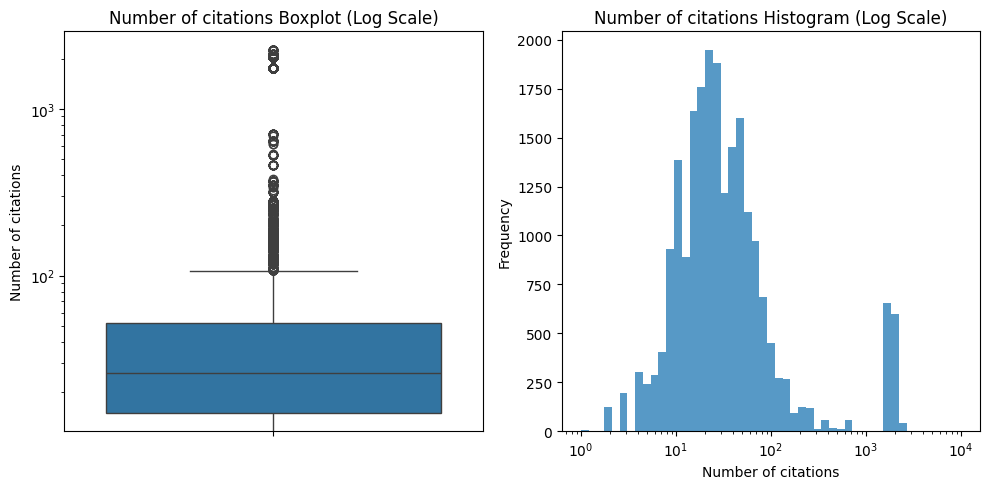

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=citations_df["citation"].dropna(), ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("Number of citations Boxplot (Log Scale)")
axes[0].set_ylabel("Number of citations")
axes[0].set_xlabel("")

sns.histplot(data=citations_df["citation"].dropna(), bins=np.logspace(0, 4), ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_title("Number of citations Histogram (Log Scale)")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Number of citations")

plt.tight_layout()
plt.show()

### OLS

In [137]:
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(citations_df[descriptors_df.columns].dropna())
)
y = citations_df["citation"][X.index].dropna()
to_drop = utils.collinear_cols(X, threshold=0.5)
model = sm.OLS(endog=y, exog=X.drop(to_drop, axis=1), hasconst=True)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               citation   R-squared:                      -0.083
Model:                            OLS   Adj. R-squared:                 -0.083
Method:                 Least Squares   F-statistic:                    -166.2
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               1.00
Time:                        13:58:21   Log-Likelihood:            -1.6482e+05
No. Observations:               21808   AIC:                         3.297e+05
Df Residuals:                   21797   BIC:                         3.298e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Molecular Weight        

### Lasso plot

In [138]:
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(citations_df[descriptors_df.columns].dropna())
)
y = citations_df["citation"][X.index].dropna()
X = X.loc[y.index]
y = pd.cut(y.loc[X.index], bins=np.logspace(0, 4, 5) - 1, labels=np.arange(4)).dropna()
X = X.loc[y.index]

results = []
for i in np.logspace(0, 1, 40):
    model = LogisticRegression(
        penalty="l1", C=1 / (i - 0.99999), solver="liblinear"
    ).fit(X, y)
    results.append(model.coef_.reshape(38))
results_df = pd.DataFrame(
    np.stack(results), index=np.logspace(0, 4, len(results)), columns=X.columns
)


fig = px.line(
    results_df,
    title="Lasso plot of coefs",
    labels={"x": "alpha regularisation strength", "y": "coefs"},
)
fig.update_layout(xaxis_type="log")

fig.show()

In [98]:
X = (
    StandardScaler()
    .set_output(transform="pandas")
    .fit_transform(citations_df[descriptors_df.columns].dropna())
)
y = citations_df["citation"][X.index].dropna()
X = X.loc[y.index]
y = pd.cut(y.loc[X.index], bins=np.logspace(0, 4, 5) - 1, labels=np.arange(4)).dropna()
X = X.loc[y.index]

# Train the Random Forest Regressor
lr = LogisticRegression(max_iter=1000, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.95)
lr.fit(X.drop(to_drop, axis=1), y)

LogisticRegression(max_iter=1000, random_state=42)

In [103]:
# Train the Random Forest Regressor
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42)
to_drop = utils.collinear_cols(X, threshold=0.95)
rf.fit(X.drop(to_drop, axis=1), y)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_6767/3344731454.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mdi_df.columns, rotation=90)


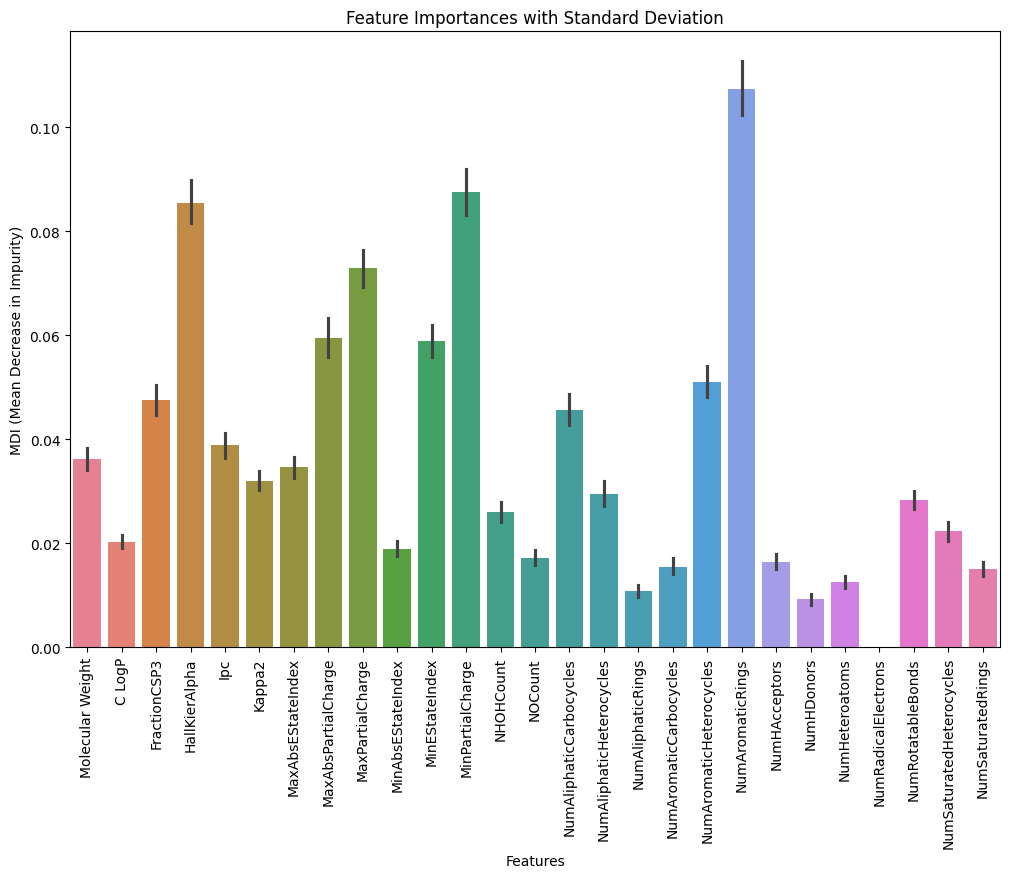

In [125]:
mdi_df = pd.DataFrame(
    data=[tree.feature_importances_ for tree in rf.estimators_],
    columns=X.drop(to_drop, axis=1).columns,
)  # drop(to_drop,axis=1).columns)

# Visualize the feature importances with Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=mdi_df,
)
ax.set_xticklabels(mdi_df.columns, rotation=90)
ax.set_ylabel("MDI (Mean Decrease in Impurity)")
ax.set_xlabel("Features")
ax.set_title("Feature Importances with Standard Deviation")
plt.show()

### Logistic Regression

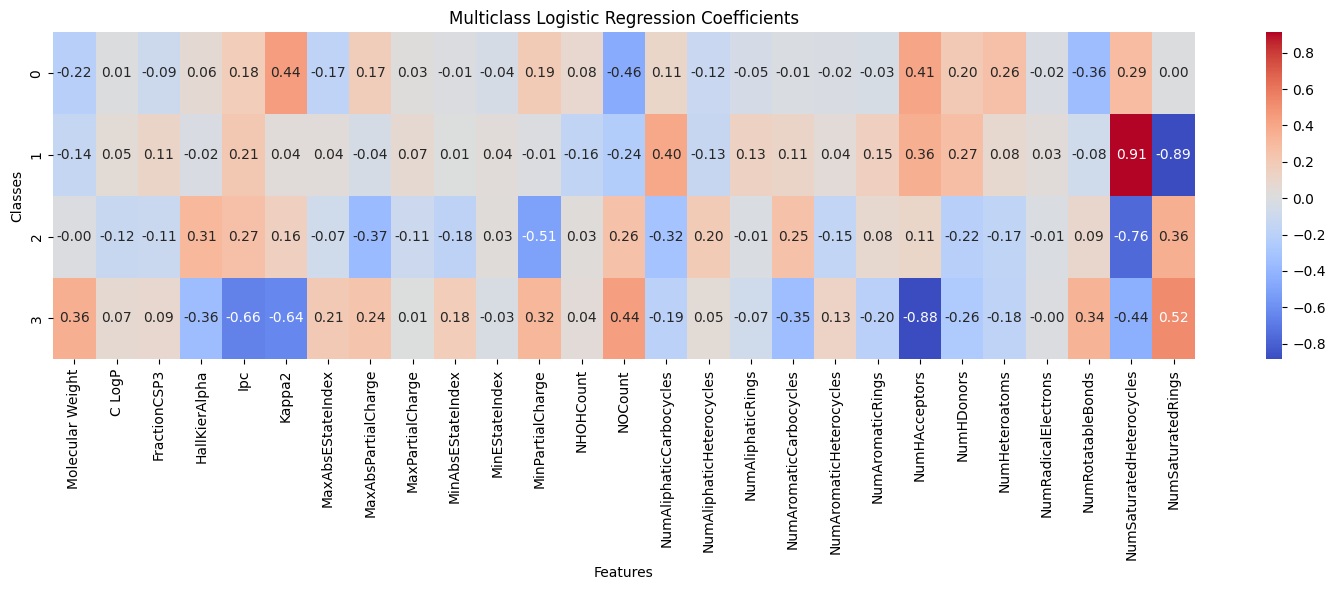

In [102]:
# Create a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(
    lr.coef_,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=X.drop(to_drop, axis=1).columns,
    yticklabels=np.arange(4),
)
plt.title("Multiclass Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

In [1]:
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    rdCoordGen,
)
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True  # Use higher quality images for molecules
import py3Dmol


def molecule_to_3d(molecule):
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    return mol

In [34]:
mol = Chem.MolFromSmiles(
    "O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=O)C(=O)N(CCCCCC(O)=O)[C@@H]1Cc1ccccc1"
)
rdCoordGen.AddCoords(mol)


def molecule_to_3d(molecule):
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    return mol


mol = molecule_to_3d(mol)
view = py3Dmol.view(
    data=Chem.MolToMolBlock(mol),  # Convert the RDKit molecule for py3Dmol
    style={"stick": {}, "sphere": {"scale": 0.3}},
)
view.setBackgroundColor("#222529")
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
with open("7jvr.pdb") as ifile:
    system = "".join([x for x in ifile])
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
view.setStyle({"model": -1}, {"cartoon": {"color": "spectrum"}})
view.setBackgroundColor("#222529")
view.zoomTo()
view.show()
view.write_html(f="7jvr.html", fullpage=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [43]:
AllChem.GenerateDepictionMatching3DStructure(mol)

ArgumentError: Python argument types in
    rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(Mol)
did not match C++ signature:
    GenerateDepictionMatching3DStructure(RDKit::ROMol {lvalue} mol, RDKit::ROMol {lvalue} reference, int confId=-1, boost::python::api::object refPatt=None, bool acceptFailure=False, bool forceRDKit=False)

In [21]:
dir(view)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_make_html',
 '_repr_html_',
 'apng',
 'endjs',
 'getModel',
 'insert',
 'model',
 'png',
 'show',
 'startjs',
 'uniqueid',
 'update',
 'updatejs',
 'viewergrid',
 'write_html']

In [27]:
"<head><style>body, html {background-color: rgb(34, 37, 41);}</style></head>view.write_html(f='mol.html')"

In [35]:
view.write_html(f="mol.html", fullpage=True)

In [14]:
from src.scripts import smiles

smiles.draw3D(
    "O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=O)C(=O)N(CCCCCC(O)=O)[C@@H]1Cc1ccccc1",
    display=True,
)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

'<div id="3dmolviewer_173454927708209"  style="position: relative; width: 640px; height: 480px;">\n        <p id="3dmolwarning_173454927708209" style="background-color:#ffcccc;color:black">3Dmol.js failed to load for some reason.  Please check your browser console for error messages.<br></p>\n        </div>\n<script>\n\nvar loadScriptAsync = function(uri){\n  return new Promise((resolve, reject) => {\n    //this is to ignore the existence of requirejs amd\n    var savedexports, savedmodule;\n    if (typeof exports !== \'undefined\') savedexports = exports;\n    else exports = {}\n    if (typeof module !== \'undefined\') savedmodule = module;\n    else module = {}\n\n    var tag = document.createElement(\'script\');\n    tag.src = uri;\n    tag.async = true;\n    tag.onload = () => {\n        exports = savedexports;\n        module = savedmodule;\n        resolve();\n    };\n  var firstScriptTag = document.getElementsByTagName(\'script\')[0];\n  firstScriptTag.parentNode.insertBefore(ta

In [7]:
%load_ext autoreload

In [12]:
%autoreload 2